# BioSimulator.jl
*Stochastic Simulation in Julia*

**Alfonso Landeros**

*University of California, Los Angeles*

In [1]:
versioninfo()

Julia Version 0.5.1
Commit 6445c82 (2017-03-05 13:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-4750HQ CPU @ 2.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


## Notebook/slides are available at [https://github.com/alanderos91/biosimulator-notebook](https://github.com/alanderos91/biosimulator-notebook)

## **BioSimulator.jl** is available at [https://github.com/alanderos91/BioSimulator.jl](https://github.com/alanderos91/BioSimulator.jl)

If you'd like to try the examples:

```bash
git clone https://github.com/alanderos91/BioSimulator.jl
```

or

```julia
Pkg.clone("https://github.com/alanderos91/BioSimulator.jl", "BioSimulator")
```

# Stochasticity in Complex Biological Systems

![figures/network.png](figures/network.png)

## Why simulation?

A **master equation** is often a useful starting point in writing down stochastic models.

$$\frac{d}{dt} p_{x,y}(t) = \sum_{j=1}^{c}\left[ p_{x,y - v^{j}}(t)a_{j}(y - v^{j}) - p_{x,y}(t)a_{j}(y) \right]$$

* The stochastic process is at a **state** $\mathbf{X}_{t} = x$ at time $t$.
* States are *discrete*; e.g. # of particle.
* States may be *multivariate*; e.g. tracking multiple particles.


* $p_{x,y}(t)$: probability of changing from state $x$ at time $0$ to state $y$ at time $t$.
* $v^{j}$: Net change due to reaction $j$ firing.
* $a_{j}(x)$: propensity of a particular transition/event/reaction $j$

The process is **memoryless**; *future events depend only on the present state* $\implies$ **Markov chains**

### Simulation samples the master equation because...

$$\frac{d}{dt} p_{x,y}(t) = \sum_{j=1}^{c}\left[ p_{x,y - v^{j}}(t)a_{j}(y - v^{j}) - p_{x,y}(t)a_{j}(y) \right]$$

* this is a system of (possibly countably-many) coupled differential equations,
* somtimes one's mathematical toolkit fails, and/or
* somtimes we want to test *simple* ideas before committing to them.

### Examples:

Given species $X$, $Y$, and $Z$, let $x = (X_{t}, Y_{t}, Z_{t})$. Some possible "rules" are

| Event/Reaction | Rule / Equation   | Propensity / Reaction Intensity                      | Change in State $v_{j}$ |
|---------------:|:------------------|:-----------------------------------------|:---------------|
| Budding        | $X \to X + X$     | $a_{1}(x) = k_{1} \cdot X$               | $(1,  0, 0)$   |
| Dimerization   | $Y + Y \to Z$     | $a_{2}(x) = k_{2} \cdot Y \cdot (Y - 1)$ | $(0, -2, 1)$   |
| Immigration    | $\emptyset \to Z$ | $a_{3}(x) = k_{3}$                       | $(0,  0, 1)$   |

## Why all the math?

### Capture essential features of a biological system

* feedback loops
* long-term dynamics
* equilibria / fixed points / stationary points
* behavior in different regimes

### Predict results in lieu of expensive or impossible experiments

* link parameters to quantities that are measurable by experimentalists
* test simple ideas before committing to a wild goose chase

## Why stochastics?

### Deterministic models have trouble capturing some features

* extinction in interesting parameter regimes
* e.g. coexistence in predator-prey systems

### Stochastic models describe a process in probabilistic terms

* allows one to quantify rare events (like extinction)
* heterogeneity within a population

## But...

![figures/could-should.png](figures/could-should.png)
## "Yeah, yeah, but your scientists were so preoccupied with whether or not they could that they didn't stop to think if they should."

### - Dr. Ian Malcolm

## Need to be careful!

Sensitivity to initial conditions (chaos) is not the same as "real noise".

| | |
|-|-|
|![](figures/cell_heterogeneity.jpeg) | ![](figures/chaos_lorenz.png) |

# Gillespie Algorithm

## What is it?

The master equation gives a simple method for simulation. At each time step:

0. Compute the propensities $a_{i}(x)$ and the cumulative intensity $\sum_{i} a_{i}(x)$.
0. **Sample the time to the next reaction $\tau$**.
0. **Sample the next reaction $j$**.
0. Update the state: $x = x + v^{j}$.

## Time to the next reaction

Think of each reaction as having its own internal alarm clock:

| |
|-|
| ![figures/gillespie_clocks.svg](figures/gillespie_clocks.svg) |

* Each event/reaction has firing time $\tau_{i} \sim \mathrm{Exponential}\left(\frac{1}{a_{i}(x)}\right)$.

* The next firing time is $\tau = \underset{i}{\min} \tau_{i} \sim \mathrm{Exponential}\left(\frac{1}{\sum_{i} a_{i}(x)}\right)$.

## Selecting the next reaction

Once we have the next firing time, we select the next reaction with probability proportional to its propensity.

| |
|-|
| ![figures/gillespie_next_reaction.png](figures/gillespie_next_reaction.png) |

## Takeaway: This approach may be useful!

* Easy to implement.
* Gillespie's algorithm gives an *exact* statistical description.
* Many variations on this idea: First Reaction Method, Next Reaction Method, ...
* Techniques for accelerating: $\tau$-leaping methods

# Enter BioSimulator.jl

## The problems to solve

This modeling tool should:

* focus on describing the modeling problem
* allow one to analyze the simulation data
* be fast
* be easy to use

## How we achieved our goals

Julia made it easy to meet all four criteria!

* It's easy to translate the math to code in Julia without worrying about performance.
* Julia is flexible enough to write nice interfaces.
* The type system helps a lot.
* Lots of Julia packages made this possible:

    - Plots.jl
    - DataFrames.jl
    - Distributions.jl
    - Reactive.jl
    - TikzGraphs.jl
    - LightGraphs.jl

### Behind the scenes

### `AbstractReactionSystem`

* dense vs sparse structure
* aka (strong vs loose coupling in reactions)
* handles the logic behind computing propensities (and derivatives)
    
### `PropensityVector`

* efficiently maintain a running sum of propensities
* avoid numerical errors
* this is essential for faster direct methods
   
   
### `Algorithm`
* `ExactMethod` and `LeapMethod`
* common interface for different algorithms
* used for dispatching and storing auxilliary variables
* no need to rewrite simulation loop

## So what does it do?

### Description

```julia
    model <= Network("example")
    
    # add different particle types
    model <= Species("X", 5)
    model <= Species("Y", 5)
    
    # add the rules
    model <= Reaction("birth", 1.0, "X --> X + X")
    model <= Reaction("death", 0.1, "X + Y --> 0")
```

### Simulation
```julia
    # Gillespie's algorithm
    simulate(model, SSA, time=100.0, epochs=100, trials=10)
    
    # Step Anticipation τ-leaping
    simulate(model, SAL, time=100.0, epochs=100, trials=10, ϵ=0.1)
```

- `epochs`: number of bins used to discretize time interval
- `trials`: number of times to repeat the simulation
- `ϵ`: special keyword argument unique to τ-leaping methods

### Supported algorithms:
* `SSA`: (the) Stochatic Simulation Algorithm / Gillespie's direct method
* `FRM`: First Reaction Method
* `NRM`: Next Reaction Method
* `ODM`: Optimized Direct Method
* `SAL`: Step Anticipation $\tau$-Leaping

## General Pattern
```julia
function simulate!(
    output    :: SimData,
    Xt        :: Vector{Int},
    algorithm :: Algorithm,
    reactions :: AbstractReactionSystem,
    trial     :: Integer
  )
  epoch = 1
  while !done(algorithm)
    t     = get_time(algorithm)
    epoch = update!(output, Xt, t, epoch, trial)

    step!(algorithm, Xt, reactions)
  end
  t = get_time(algorithm)
  update!(output, Xt, t, epoch, trial)

  return output
end
```

## Example: Gillespie's Direct Method

```julia
function step!(algorithm::SSA, Xt::Vector, r::AbstractReactionSystem)
  a = propensities(r)

  if intensity(a) > 0
    τ = compute_stepsize(a)

    set_time!(algorithm, τ)

    if !done(algorithm)
      μ = select_reaction(a)
      fire_reaction!(Xt, r, μ)
      update_propensities!(a, r, Xt, μ)
    end

  elseif intensity(a) == 0
    algorithm.t = algorithm.end_time
  else
    println("t = ", get_time(algorithm))
    println("a = ", a)
    println("Xt = ", Xt)
    error("intensity = ", intensity(a))
  end

  return nothing
end
```

## Benchmarks

Comparisons based on the default settings, using Gillespie's direct method, in seconds:

| Model            |    StochPy | StochKit | BioSimulator.jl (single) | BioSimulator.jl (parallel) |
|:----------------:|-----------:|---------:|-------------------------:|---------------------------:|
| Kendall's Process|  21.611453 | 0.241834 |                 0.088413 |                   0.031338 |
| Michaelis-Menten |  22.903635 | 0.194554 |                 0.075246 |                   0.026254 |
| Chain (1000)     | 290.734749 |  1.05734 |                 4.221896 |                   1.516823 |
| Autoreg          |          - |  55.6402 |               111.908453 |                  28.185955 |

* **Kendall's Process**: birth-death-immigration process with analytic solution
* **Michaelis-Menten**: theoretical model for enzyme kinetics
* **Chain**: measures efficiency of the search on propensities
* **Autoreg**: simple self-regulation network of a gene (see examples)

### Note: These results are for *multiple* realizations (i.e. `trials > 1`).

### Remarks

* **StochKit** selects an efficient algorithm given an algorithm class (e.g. SSA vs $\tau$-leaping). It is using an optimized version of the direct method.
* **StochKit** uses parallelism by default (8 threads on my machine).
* **StochPy** records the state after every event (dynamic memory allocation). Comparison is biased against it.
* **BioSimulator.jl** is slower than it should be because the parallelism is implemented in a "very naive" way.

### Takeaway

**The gap between a Julia implementation and a mature C++ library is small.** Julia is great!

## Kendall's Process

1. Birth, $X \to X + X$
2. Death, $X \to \emptyset$
3. Immigration, $\emptyset \to X$

## Michaelis-Menten

1. Binding, $S + E \to SE$
2. Dissociation, $SE \to S + E$
3. Conversion, $SE \to P + E$

## Chain

$X_{1} \leftrightarrow X_{2} \leftrightarrow \ldots \leftrightarrow X_{M}$

## Examples

### Gene Regulation

Given a single gene, we consider the following set of "rules":

0. transcription of RNA from the gene
0. translation of RNA to the protein
0. dimerization of the protein into the supressive dimer form
0. dissociation of the dimer
0. blocking transcritpion via a dimer molecule
0. unblocking transcription
0. RNA degradation
0. protein degradation

| |
|-|
| ![](figures/auto-regulation.png) |

In [2]:
genenet = Network("self-regulation")

genenet <= Species("gene",   10)
genenet <= Species("P2_gene", 0)
genenet <= Species("RNA",     0)
genenet <= Species("P",       0)
genenet <= Species("P2",      0)

genenet <= Reaction("repression binding", 1.0, "gene + P2 --> P2_gene")
genenet <= Reaction("reverse repression binding", 10.0, "P2_gene --> gene + P2")
genenet <= Reaction("transcription", 0.1, "gene --> gene + RNA")
genenet <= Reaction("translation", 10.0, "RNA --> RNA + P")
genenet <= Reaction("dimerization", 1.0, "P + P --> P2")
genenet <= Reaction("dissociation", 1.0, "P2 --> P + P")
genenet <= Reaction("RNA degradation", 0.1, "RNA --> 0")
genenet <= Reaction("protein degradation", 0.01, "P --> 0")

genenet

[ Model: self-regulation ]
 no. species:    5
 no. reactions:  8

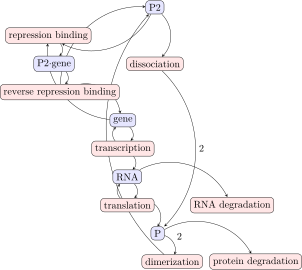

In [3]:
visualize(genenet)

In [4]:
genenet_result = simulate(genenet, time=100.0, epochs=10_000, trials=100)

SimData{5,10001,100}
 * species  = ("P2","RNA","P","P2_gene","gene")
 * time     = 100.0
 * epochs   = 10001
 * trials   = 100

In [26]:
get_dataframe(genenet_result)[700:709, :]

,time,P2,RNA,P,P2_gene,gene,trial
1,6.99,99,4,17,8,2,1
2,7.0,99,4,15,9,1,1
3,7.01,99,4,18,8,2,1
4,7.02,100,4,18,8,2,1
5,7.03,99,4,18,9,1,1
6,7.04,98,4,21,9,1,1
7,7.05,100,4,17,9,1,1
8,7.06,98,4,19,10,0,1
9,7.07,102,4,11,10,0,1
10,7.08,101,4,17,9,1,1


In [6]:
using Plots
gr()

p = plot(MeanTrajectory(genenet_result, "P"))
plot!(p, MeanTrajectory(genenet_result, "P2"))

savefig(p, "figures/autoreg01.svg")

![figures/autoreg.svg](figures/autoreg01.svg)

In [7]:
p = plot(legend=false, title="dimer P2 over time")

for i = 1:3
    plot!(Trajectory(genenet_result, "P2", i), label="trial $i")
end

savefig(p, "figures/autoreg02.svg")

![mytest.svg](figures/autoreg02.svg)

In [8]:
p = plot(
    plot(Trajectory(genenet_result, "P",   1), xlab="", ylab="protein"),
    plot(Trajectory(genenet_result, "P2",  1), xlab="", ylab="dimer"),
    plot(Trajectory(genenet_result, "RNA", 1), xlab="", ylab="RNA"),
    plot(Trajectory(genenet_result, "P2_gene", 1),      ylab="blocked"),
    layout = (4, 1),
    legend = false
)

savefig(p, "figures/autoreg03.svg")

![figures/autoreg03.svg](figures/autoreg03.svg)

In [9]:
p = plot(Histogram(genenet_result, "P2", 100),
    label="P2",
    title="distribution of dimer at t = 100"
)

savefig(p, "figures/autoreg04.svg")

INFO: binning = auto


![figures/autoreg04.svg](figures/autoreg04.svg)

### Brusselator Cascade

The [Brusselator](https://en.wikipedia.org/wiki/Brusselator) is a theoretical model of a type of autocatalytic reaction. A species $X$ is catalyzed by $Y$,

0. $A \to X$
0. $2X + Y \to 3X$
0. $X + B \to Y + D$
0. $X \to E$

The deterministic version predicts a stable fixed point at $(X, Y) = (A, B / A)$ when rate constants are 1.

![figures/brusselator_blocks.png](figures/brusselator_blocks.png)

In [10]:
brussel = Network("Brusselator")

N = 20    # number of Brusselators
V = 100.0 # system volume

# ===== Deterministic Rates =====
k1 = 1.0  # buffer rate
k2 = 1.0  # transition/decay rate
k3 = 1.0  # conversion rate
k4 = 1.0  # autocatalytic rate

# ===== Stochastic Rates =====
# To model a constant buffer X0 we add a zero-order reaction (like immigration)
# The stochastic rates have to take into account the system volume

γ1 = k1                    # buffer rate
γ2 = k2 / V                # transition/decay rate
γ3 = k3 / V                # conversion rate
γ4 = 2 * k4 / (V * V * V)  # autocatalytic rate

for i = 1:N
    # species definitions
    brussel <= Species("X$(i)", 0)
    brussel <= Species("Y$(i)", 0)

    # autocatalytic reactions
    brussel <= Reaction("conversion$(i)",    γ3, "X$(i) --> Y$(i)")
    brussel <= Reaction("autocatalysis$(i)", γ4, "X$(i) + X$(i) + Y$(i) --> X$(i) + X$(i) + X$(i)")
end

for i = 2:N
    # cascades
    brussel <= Reaction("cascade$(i)", γ2, "X$(i-1) --> X$(i)")
end

brussel <= Reaction("buffer", γ1, "0 --> X1")
brussel <= Reaction("decay",  γ2, "X$(N) --> 0")

brussel

[ Model: Brusselator ]
 no. species:    40
 no. reactions:  61

In [11]:
brussel_result = simulate(brussel, time=10_000.0, epochs=10_000)

p1 = plot(Trajectory(brussel_result, "X1", 1))
plot!(p1, Trajectory(brussel_result, "Y1", 1), ylab="avg. no. at stage 1")

p2 = plot(Trajectory(brussel_result, "X20", 1))
plot!(p2, Trajectory(brussel_result, "Y20", 1), ylab="avg. no. at stage 20")

plot(p1, p2, layout = (2, 1))

savefig("figures/brusselator01.svg")

![figures/brusselator01.svg](figures/brusselator01.svg)

In [12]:
# NOTE: the GIF takes awhile!

n = size(brussel_result.data, 2)
x1max  = maximum(brussel_result["X1"])
y1max  = maximum(brussel_result["Y1"])
x20max = maximum(brussel_result["X20"])
y20max = maximum(brussel_result["Y20"])

anim = @animate for i = 1:n
    x1 = brussel_result["X1"][1:i, 1]
    y1 = brussel_result["Y1"][1:i, 1]
    
    x20 = brussel_result["X20"][1:i, 1]
    y20 = brussel_result["Y20"][1:i, 1]
    
    plot(
        plot(x1,  y1,  xlim=(0, x1max),  ylim=(0, y1max),  xlab="X1",  ylab="Y1",  title="stage 1"),
        plot(x20, y20, xlim=(0, x20max), ylim=(0, y20max), xlab="X20", ylab="Y20", title="stage 20"),
        size = (800, 350),
        legend = false
        )
end every 100

gif(anim, "figures/brusselator02.gif");

INFO: Saved animation to /Users/marysehl/Documents/2016-2017/CNTA/presentation/figures/brusselator02.gif


![figures/brusselator02.gif](figures/brusselator02.gif)

## Acknowledgments

* Advisors: Dr. Mary Sehl and Dr. Kenneth Lange
* UCLA Biomathematics Department
* Carol Newton Travel Award

# Thank you for listening!

# References